<a href="https://colab.research.google.com/github/Baekseunghwa/Convolutional-Neural-Network/blob/master/LogD_prediction_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction LogP using SMILES and CNN

In [175]:
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

big = 267
num_epochs = 10
batch_size = 128
learning_rate = 0.003

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print('Modules are successfully brought.',"The PyTorch Version of your computer is:",torch.__version__)

Modules are successfully brought. The PyTorch Version of your computer is: 1.3.1


In [0]:
vocab = [' ', 'c', 'C', '(', ')', 'O', '1', '2', 'N', '=', '[', ']', '@', '3', 'H', 'n', '4', 'F', '+', 'S', 'l', 's', '/', 'o', '-', '5', '#', 'B', 'r', '\\', '6', '7','P','I','i','8','e','.','9','%','0']
def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles)<max_length:
            smiles +=" "
        return [vocab.index(str(x)) for x in smiles]

    smi_total = []
    for smi in smi_list:
        smi_onehot = smiles_to_vector(smi, vocab, big)
        smi_total.append(smi_onehot)
    return np.asarray(smi_total)

# Data Read 

In [177]:
import torch
import numpy as np 
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader

dataset = np.loadtxt('Lipophilicity.csv', delimiter=',', dtype=np.string_)

print(vocab)


[' ', 'c', 'C', '(', ')', 'O', '1', '2', 'N', '=', '[', ']', '@', '3', 'H', 'n', '4', 'F', '+', 'S', 'l', 's', '/', 'o', '-', '5', '#', 'B', 'r', '\\', '6', '7', 'P', 'I', 'i', '8', 'e', '.', '9', '%', '0']


In [0]:
def smiles_to_array(smi_list):
  def smiles_to_array_vector(smiles, vocab, depth):
    smile_total = []
    for i in range(depth) :
      if(i!=0):
        a = []
        for j in range(big):
          if(smiles[j] == i):
            a.append(1)
          else :
            a.append(0)
        smile_total.append(a)
    return smile_total
  smile_total = []
  for smi in smi_list :
    smi_array = smiles_to_array_vector(smi,vocab,len(vocab))
    smile_total.append(smi_array)
  return smile_total

In [0]:
CMPD_CHMBLID = dataset[:,0]
exp = dataset[:,1]
SMILES = dataset[:,2]

exp = exp[1:-1].astype(float)
SMILES = SMILES[1:-1].astype(str)
SMILES = smiles_to_onehot(SMILES)
SMILES = smiles_to_array(SMILES)

data = []
for smi in SMILES :
  data.append(smi)


In [0]:
exp_train = exp[1000:-1]
exp_test = exp[0:999]

SMILES_train = data[1000:-1]
SMILES_test = data[0:999]

class DiabetesDataset(Dataset): 
  """ Diabetes dataset."""
  def __init__(self,data1,data2):
        self.len = len(data1)
        self.x_data = torch.as_tensor(data1)
        self.y_data = torch.tensor(data2)

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

In [0]:
dataset_train = DiabetesDataset(SMILES_train,exp_train)
train_loader = DataLoader(dataset=dataset_train,
                          batch_size=200,
                          shuffle=True,
                          num_workers=2)

dataset_test = DiabetesDataset(SMILES_test,exp_test)
test_loader = DataLoader(dataset=dataset_test,
                          batch_size=1,
                          shuffle=False,
                          num_workers=2)

In [182]:
a= torch.tensor(SMILES_test[3])
a.size()

torch.Size([40, 267])

# Making Layer

In [0]:
class simple_CNN(nn.Module):
    def __init__(self):
        super(simple_CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv1d(in_channels = 40, out_channels = 64, kernel_size = 9),
                                   nn.ReLU(),
                                   nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 9),
                                   nn.ReLU(),
                                   nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 9),
                                   nn.ReLU(),
                                   nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 9),
                                   nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(64*235,1024),
                                   nn.ReLU(),
                                   nn.Linear(1024,1024),
                                   nn.ReLU(),
                                   nn.Linear(1024,1024),
                                   nn.ReLU(),
                                   nn.Linear(1024,1))

    def forward(self, x):
      out = self.layer1(x)
      out = out.view(out.size(0),-1)
      out = self.layer2(out)
      return out

In [190]:
model = simple_CNN()
model.to(device)

simple_CNN(
  (layer1): Sequential(
    (0): Conv1d(40, 64, kernel_size=(9,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(9,), stride=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 64, kernel_size=(9,), stride=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(64, 64, kernel_size=(9,), stride=(1,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=15040, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1, bia

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
import matplotlib.pyplot as plt

def test() :
  x = []
  y = []
  mse = 0
  for images, labels in test_loader:
    images = images.to(device,dtype= torch.float)
    labels = labels.to(device,dtype= torch.float)
    outputs = model(images)
    x.append(labels.data)
    y.append(outputs.data)
    mse += ((labels.data - outputs.data))**2
  mse = (mse/1000)**0.5
  print('mse = %f' %(mse))
  fig = plt.figure()
  plt.plot(x,y,'ro')
  plt.show()

epoch : 0 	 Loss : 2.158327
mse = 1.525231


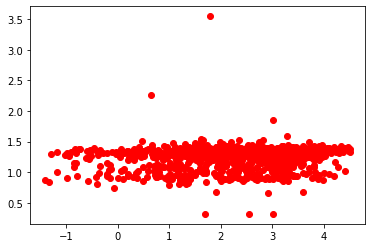

epoch : 1 	 Loss : 1.332171
mse = 1.237819


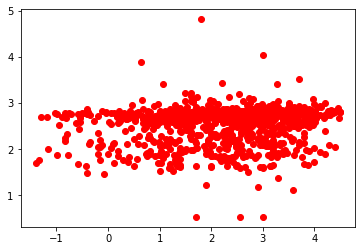

epoch : 2 	 Loss : 1.517401
mse = 1.198332


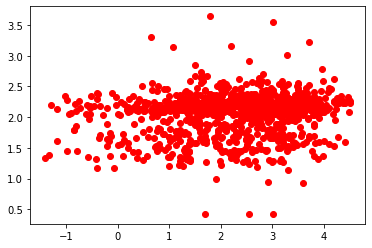

epoch : 3 	 Loss : 1.446643
mse = 1.210223


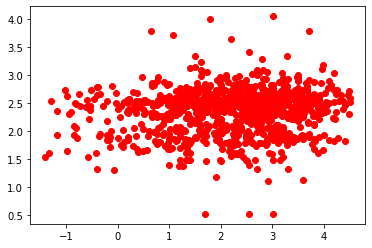

epoch : 4 	 Loss : 1.209180
mse = 1.206183


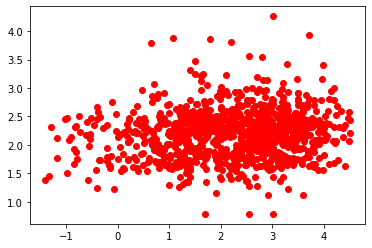

epoch : 5 	 Loss : 1.397635
mse = 1.215484


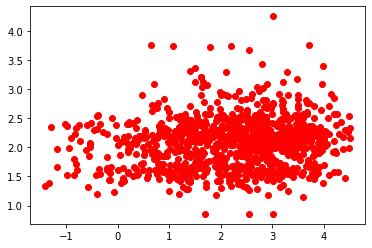

epoch : 6 	 Loss : 1.312784
mse = 1.199274


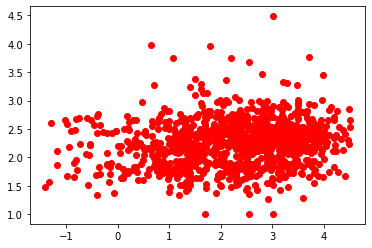

epoch : 7 	 Loss : 1.055439
mse = 1.209716


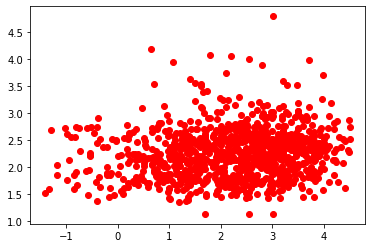

epoch : 8 	 Loss : 1.124846
mse = 1.208838


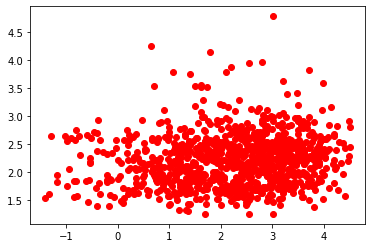

epoch : 9 	 Loss : 1.142744
mse = 1.215332


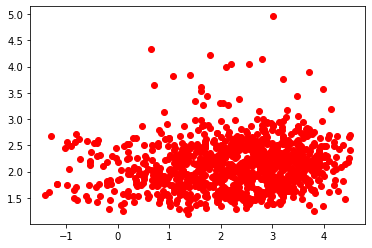

epoch : 10 	 Loss : 1.078276
mse = 1.225761


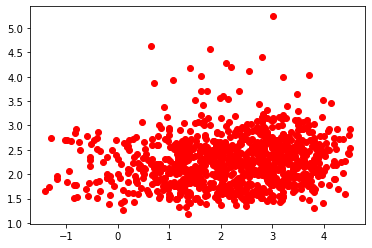

epoch : 11 	 Loss : 0.896324
mse = 1.257291


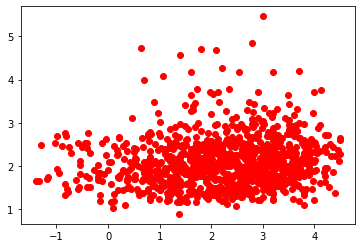

epoch : 12 	 Loss : 1.175227
mse = 1.235881


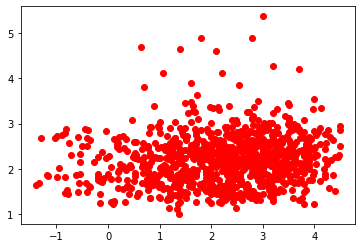

epoch : 13 	 Loss : 1.021860
mse = 1.249041


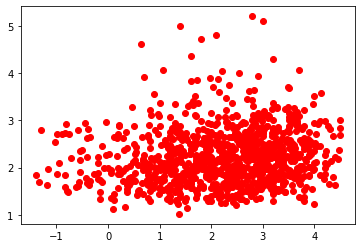

epoch : 14 	 Loss : 0.899304
mse = 1.261370


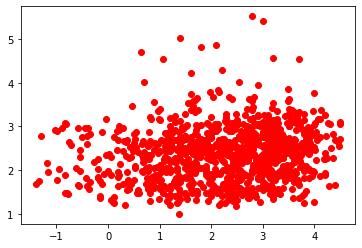

epoch : 15 	 Loss : 0.950234
mse = 1.254305


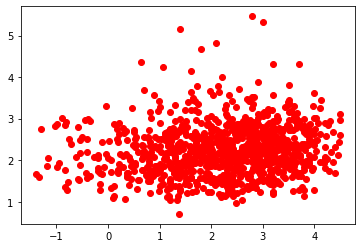

epoch : 16 	 Loss : 0.707282
mse = 1.252021


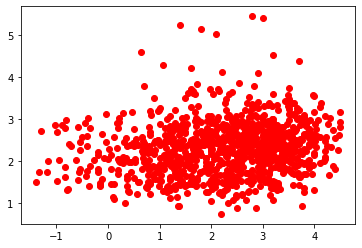

epoch : 17 	 Loss : 0.944969
mse = 1.266116


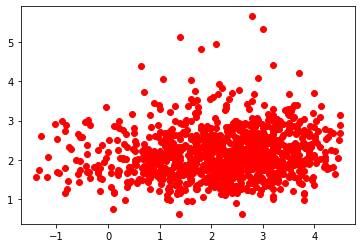

epoch : 18 	 Loss : 1.093197
mse = 1.237329


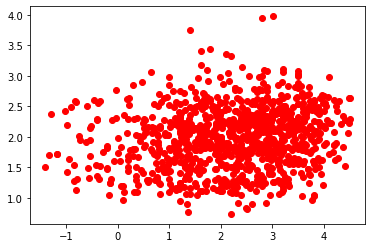

epoch : 19 	 Loss : 0.940075
mse = 1.231326


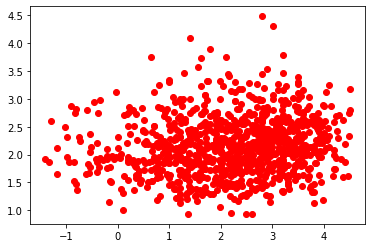

In [193]:
for epoch in range(20):
    for i, (images,labels) in enumerate(train_loader):
#        images = images.view(-1,784)
        images = images.to(device,dtype= torch.float)
        labels = labels.to(device,dtype= torch.float)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze()
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
    print("epoch : %d \t Loss : %f" %(epoch,loss))
    test()


epoch : 0 	 Loss : 0.215316
mse = 0.979367


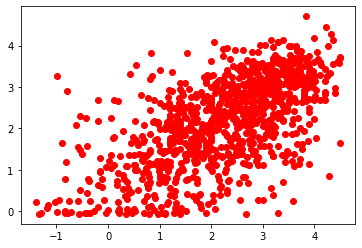

epoch : 1 	 Loss : 0.220834
mse = 1.007423


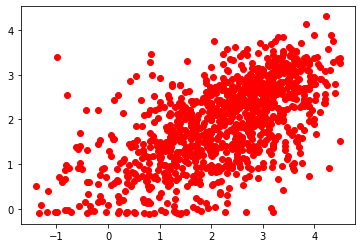

epoch : 2 	 Loss : 0.271224
mse = 1.013078


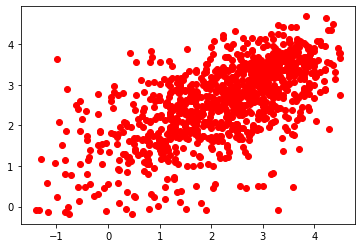

epoch : 3 	 Loss : 0.304161
mse = 1.006914


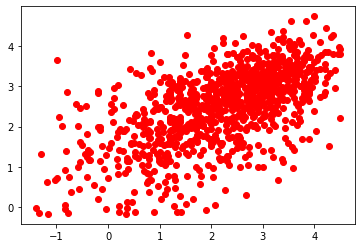

epoch : 4 	 Loss : 0.244688
mse = 0.956511


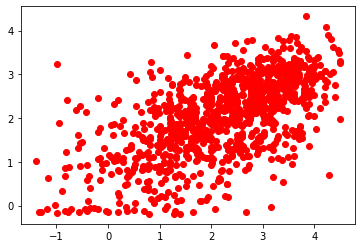

epoch : 5 	 Loss : 0.238217
mse = 0.939622


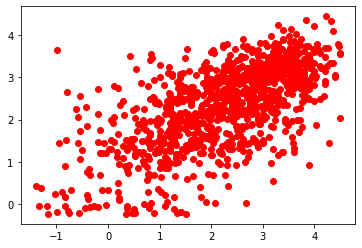

epoch : 6 	 Loss : 0.174622
mse = 0.936981


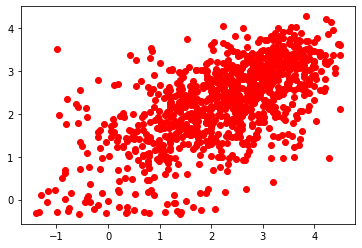

epoch : 7 	 Loss : 0.182450
mse = 0.948373


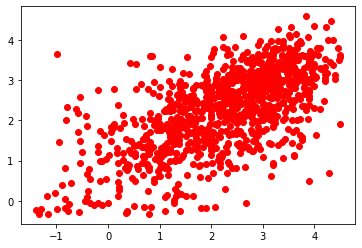

epoch : 8 	 Loss : 0.278162
mse = 0.972248


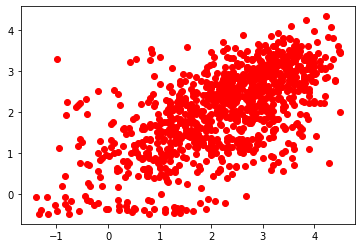

epoch : 9 	 Loss : 0.220163
mse = 1.009288


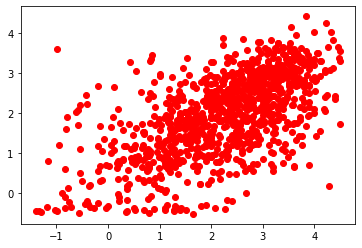

epoch : 10 	 Loss : 0.194978
mse = 0.974892


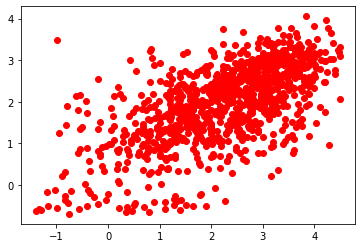

epoch : 11 	 Loss : 0.184046
mse = 0.940567


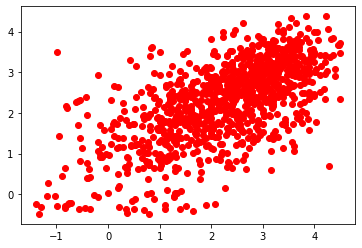

epoch : 12 	 Loss : 0.187761
mse = 1.002873


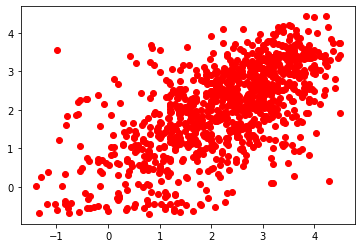

epoch : 13 	 Loss : 0.157924
mse = 0.961030


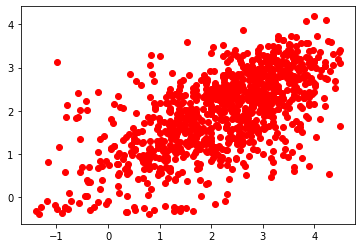

epoch : 14 	 Loss : 0.151601
mse = 0.938683


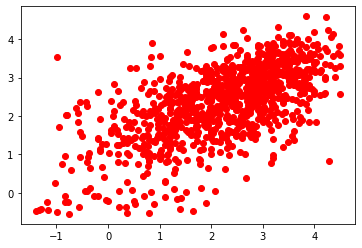

epoch : 15 	 Loss : 0.109482
mse = 0.958427


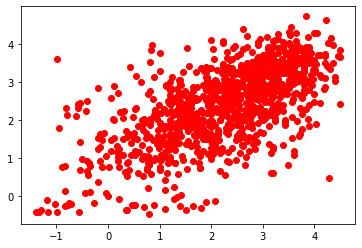

epoch : 16 	 Loss : 0.129388
mse = 1.023761


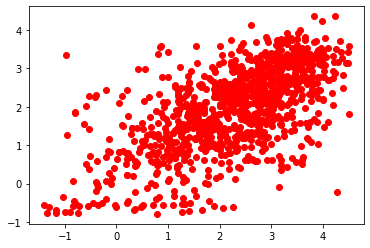

epoch : 17 	 Loss : 0.118046
mse = 0.952029


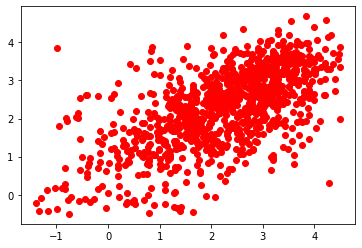

epoch : 18 	 Loss : 0.104254
mse = 0.968218


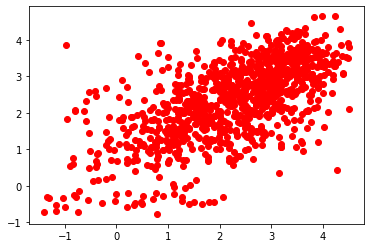

epoch : 19 	 Loss : 0.118359
mse = 0.956393


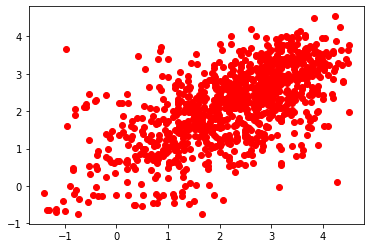

In [188]:
for epoch in range(20):
    for i, (images,labels) in enumerate(train_loader):
#        images = images.view(-1,784)
        images = images.to(device,dtype= torch.float)
        labels = labels.to(device,dtype= torch.float)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze()
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
    print("epoch : %d \t Loss : %f" %(epoch,loss))
    test()


In [0]:
  x = []
  y = []
  mse = 0
  for images, labels in train_loader:
    images = images.to(device,dtype= torch.float)
    labels = labels.to(device,dtype= torch.float)
    outputs = model(images)
    x.append(labels.data)
    y.append(outputs.data)
    mse += ((labels.data - outputs.data))**2
  mse = (mse/1000)**0.5
  print('mse = %f' %(mse))
  fig = plt.figure()
  plt.plot(x,y,'ro')
  plt.show()